#Libraries


##Zip files upload and unzipped here (optional)

In [ ]:
from functools import wraps

def time_it(func):
    import time
    @wraps(func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result =  func(*args, **kwargs)
        t2 = time.time()
        print(f"{t2-t1} sec(s) for function {func.__name__}")  
        return result
    return wrapper

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip /content/drive/My\ Drive/datasets/datasets.zip

In [ ]:
from tensorflow.keras import Sequential, Model, regularizers
from tensorflow.keras.layers import (Conv2D, ZeroPadding2D, Activation, Input,
                                     SeparableConv2D, BatchNormalization,
                                     MaxPooling2D, AveragePooling2D, Lambda,
                                     Flatten, Dense,Dropout)

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                 img_to_array)
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import os
from PIL import Image
from tensorflow.keras.losses import BinaryCrossentropy
%matplotlib inline
import concurrent.futures as multi
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import classification_report


#### Preprocess Data Sparse Categorical

In [ ]:
base = os.getcwd()
datasets = os.path.join(base,'unprocessed')
#train = os.path.join(datasets,'train')

###Image Data Generator


In [ ]:
#Lets move smoke images
'''import shutil
smoke = os.path.join(train,"smoke")
fire = os.path.join(train,"fire")
i = 0
for image in os.listdir(smoke):
  file_name = os.path.join(smoke,image)
  try:
    shutil.move(file_name, fire)
  except:
    os.rename(file_name, os.path.join(fire,f"smokey_{i}.jpg"))
    i += 1'''

'import shutil\nsmoke = os.path.join(train,"smoke")\nfire = os.path.join(train,"fire")\ni = 0\nfor image in os.listdir(smoke):\n  file_name = os.path.join(smoke,image)\n  try:\n    shutil.move(file_name, fire)\n  except:\n    os.rename(file_name, os.path.join(fire,f"smokey_{i}.jpg"))\n    i += 1'

In [ ]:
'''def change_file(scan_file):
      image = Image.open(scan_file.path)
      image = image.convert("RGB")
      image.save(scan_file.path)'''

'def change_file(scan_file):\n      image = Image.open(scan_file.path)\n      image = image.convert("RGB")\n      image.save(scan_file.path)'

In [ ]:
'''import time
t1 = time.time()
for folder in os.scandir(datasets):
  for di in os.scandir(folder.path):
      files = os.scandir(di.path)
      with multi.ThreadPoolExecutor() as executor:
        executor.map(change_file,files)
t2 = time.time()
print(f"{t2-t1} secs")'''

'import time\nt1 = time.time()\nfor folder in os.scandir(datasets):\n  for di in os.scandir(folder.path):\n      files = os.scandir(di.path)\n      with multi.ThreadPoolExecutor() as executor:\n        executor.map(change_file,files)\nt2 = time.time()\nprint(f"{t2-t1} secs")'

In [ ]:
data_gen = ImageDataGenerator(
    rescale = 1./255,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rotation_range=10,
	  zoom_range=0.15,
	  shear_range=0.15,
	  fill_mode="nearest"
)
BATCH_SIZE = 64
IMG_HEIGHT = 128
IMG_WIDTH = 128
DEPTH = 3
# GEt data from directories
class_names=["default", "fire_smoke"]
train_generator = data_gen.flow_from_directory(
        datasets,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True,
        color_mode="rgb",
        classes=class_names,
        subset='training'
)

Found 0 images belonging to 2 classes.


In [ ]:
val_generator = data_gen.flow_from_directory(
        datasets,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        color_mode="rgb",
        classes=class_names,
        subset='validation'
)

Found 1331 images belonging to 2 classes.


In [ ]:
# GEt data from directories
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        '/content/drive/My Drive/datasets/Tests/imgs',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary',
        shuffle=True,
        classes=class_names)

Found 60 images belonging to 2 classes.


###Inspect a batch

In [ ]:
from math import ceil,sqrt
def show_batch(image_batch, label_batch, batch_size):
  grid = ceil(sqrt(batch_size))
  plt.figure(figsize=(10,10))
  fire=0
  non = 0
  for n in range(batch_size):
      ax = plt.subplot(grid, grid,n+1)
      plt.imshow(image_batch[n])
      if int(label_batch[n]) == 1:
        fire += 1
      elif int(label_batch[n]) == 0:
        non += 1 
      plt.title(class_names[int(label_batch[n])])
      plt.axis('off')
  print(f"fire = {fire}, Non_fire = {non}")

IndexError: ignored

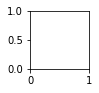

In [ ]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch, BATCH_SIZE)

fire = 37, Non_fire = 27


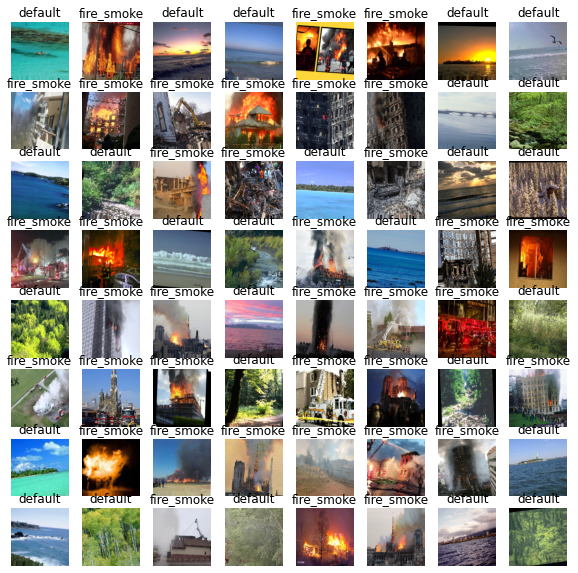

In [ ]:
image_batch, label_batch = next(val_generator)
show_batch(image_batch, label_batch, BATCH_SIZE)

#Modelling

####Basic Module


In [ ]:
def basic_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  return model

In [ ]:
model = basic_model()
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

In [ ]:
history = model.fit(
    x=train_generator,
    validation_data = val_generator,
    epochs=8)

Epoch 1/8
71/84 [========================>.....] - ETA: 10s - loss: 0.6433 - accuracy: 0.6745

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


84/84 [==============================] - 93s 1s/step - loss: 0.6338 - accuracy: 0.6917 - val_loss: 0.5662 - val_accuracy: 0.7333
Epoch 2/8
84/84 [==============================] - 92s 1s/step - loss: 0.4784 - accuracy: 0.7856 - val_loss: 0.5211 - val_accuracy: 0.8032
Epoch 3/8
84/84 [==============================] - 92s 1s/step - loss: 0.3770 - accuracy: 0.8345 - val_loss: 0.4897 - val_accuracy: 0.8385
Epoch 4/8
84/84 [==============================] - 92s 1s/step - loss: 0.3642 - accuracy: 0.8450 - val_loss: 0.4506 - val_accuracy: 0.8062
Epoch 5/8
84/84 [==============================] - 92s 1s/step - loss: 0.3372 - accuracy: 0.8570 - val_loss: 0.4376 - val_accuracy: 0.8355
Epoch 6/8
84/84 [==============================] - 93s 1s/step - loss: 0.3340 - accuracy: 0.8659 - val_loss: 0.4061 - val_accuracy: 0.8467
Epoch 7/8
84/84 [==============================] - 93s 1s/step - loss: 0.2876 - accuracy: 0.8824 - val_loss: 0.3776 - val_accuracy: 0.8445
Epoch 8/8
84/84 [====================

#### Keras Pretrained Resnet 50


In [ ]:
from tensorflow.keras.applications import ResNet50V2
resnet_model = ResNet50V2(
    include_top=False, #Most important--last layer is not included
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, DEPTH),
    pooling=None,
    classifier_activation=None,)
resnet_model.trainable = False# freeze the orignianl layers of the resnet model

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
#Functional Model
def shorter_fn_model():
  X = resnet_model.layers[-1].output
  X = Flatten()(X)
  #X = Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(X)
  X = Dense(8, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(X)
  X = Dense(1,activation='sigmoid')(X)
  shorter_model = Model(resnet_model.inputs, outputs=X)
  return shorter_model

In [ ]:
#Combining the both models in Sequential 
def top_off():
  my_model = Sequential()
  my_model.add(resnet_model)
  my_model.add(Flatten())
  my_model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  my_model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
  my_model.add(Dense(1,activation='sigmoid'))
  return my_model

In [ ]:
my_model = shorter_fn_model()
my_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', 
                     save_weights_only=True, save_best_only=True)
callback_list = []
callback_list.append(mc)
my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
EPOCHS = 20
history = my_model.fit(
    x=train_generator,
    #steps_per_epoch = train_generator.samples, #// batch_size,
    validation_data = val_generator, 
    #validation_steps = val_generator.samples, #// batch_size,
    epochs = EPOCHS,
    callbacks= callback_list)

Epoch 1/20
29/84 [=========>....................] - ETA: 44s - loss: 0.3089 - accuracy: 0.8836

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


84/84 [==============================] - 96s 1s/step - loss: 0.2400 - accuracy: 0.9090 - val_loss: 0.2179 - val_accuracy: 0.9076
Epoch 2/20
84/84 [==============================] - 93s 1s/step - loss: 0.1580 - accuracy: 0.9437 - val_loss: 0.1969 - val_accuracy: 0.9309
Epoch 3/20
84/84 [==============================] - 96s 1s/step - loss: 0.1238 - accuracy: 0.9567 - val_loss: 0.1561 - val_accuracy: 0.9474
Epoch 4/20
84/84 [==============================] - 95s 1s/step - loss: 0.1106 - accuracy: 0.9632 - val_loss: 0.1702 - val_accuracy: 0.9399
Epoch 5/20
84/84 [==============================] - 92s 1s/step - loss: 0.0981 - accuracy: 0.9698 - val_loss: 0.2139 - val_accuracy: 0.9324
Epoch 6/20
84/84 [==============================] - 93s 1s/step - loss: 0.0913 - accuracy: 0.9709 - val_loss: 0.2018 - val_accuracy: 0.9354
Epoch 7/20
84/84 [==============================] - 94s 1s/step - loss: 0.0885 - accuracy: 0.9737 - val_loss: 0.2008 - val_accuracy: 0.9459
Epoch 8/20
84/84 [=============

## Graphs about accuracy and loss

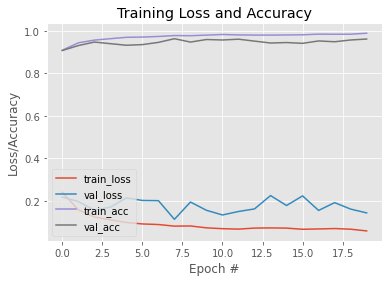

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
fig = plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

#Evaluation

In [ ]:
my_model.save_weights("best_model")

In [ ]:
my_model.evaluate(x=val_generator)

38/38 [==============================] - 64s 2s/step - loss: 0.2246 - accuracy: 0.9099


[0.22463522851467133, 0.9099173545837402]

In [ ]:
my_model.save_weights('./Epochs_20.h5', overwrite=True)

In [ ]:
cpu_model = shorter_fn_model()
cpu_model.load_weights('./best_model.h5')
cpu_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

OSError: ignored

In [ ]:
import matplotlib.pyplot as plt
from math import ceil
def plot_predictions(images, labels, predictions):
  plt.figure(figsize=(10,10))
  for i in range(images.shape[0]):
    plt.subplot(ceil(images.shape[0]/5)+1,ceil(images.shape[0]/5)+1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    if int(labels[i]) == 0:
      if np.argmax(predictions[i]) == 0:
        plt.xlabel("Non-Fire", color='green')
      else:
        plt.xlabel("Non-Fire", color='red')
    elif int(labels[i]) == 1:
      if np.argmax(predictions[i])== 1:
        plt.xlabel("Fire", color='green')
      else:
        plt.xlabel("Fire", color='red')

  plt.show()

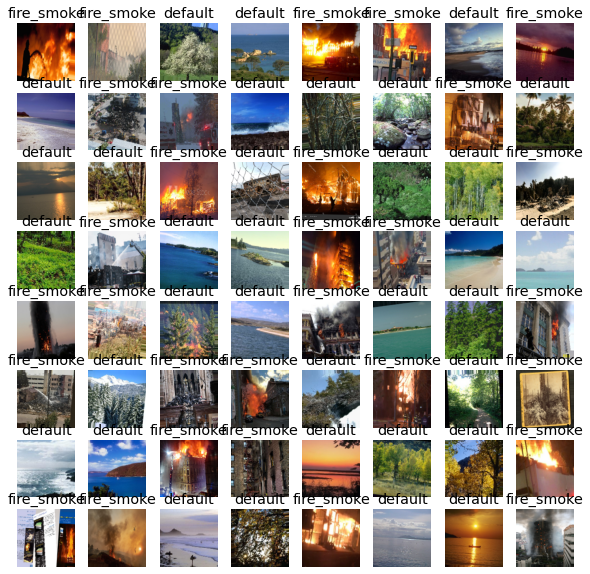

In [ ]:
image_batch, label_batch = next(val_generator)
plot_predictions(image_batch,my_model.predict(image_batch))

In [ ]:
from google.colab import files
files.download("./best_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

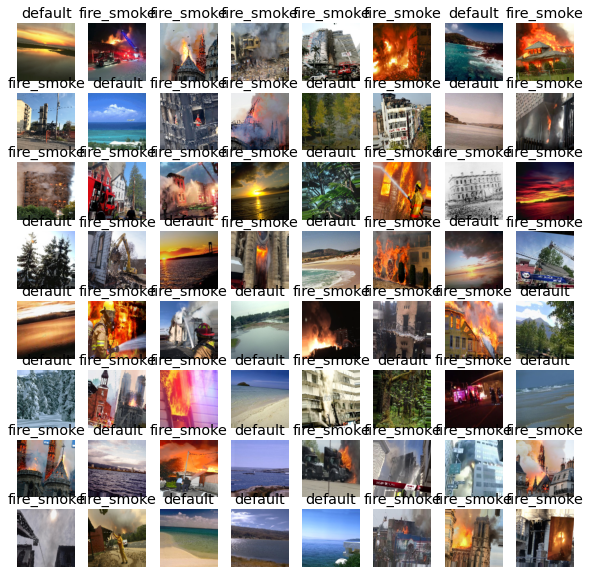

In [ ]:
image_batch, label_batch = next(val_generator)
plot_predictions(image_batch,my_model.predict(image_batch))

In [ ]:
test_folder = os.path.join(base,'drive')
test_folder = os.path.join(test_folder,'My Drive')
test_folder = os.path.join(test_folder,'datasets')
test_folder = os.path.join(test_folder,'Tests')
test_folder = os.path.join(test_folder,'imgs')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=class_name
)

Found 60 images belonging to 2 classes.


In [ ]:
my_model.evaluate(x = test_generator)

2/2 [==============================] - 4s 2s/step - loss: 0.8259 - accuracy: 0.7333


[0.8259389400482178, 0.7333333492279053]

In [ ]:
cpu_model.evaluate(x = test_generator)

2/2 [==============================] - 4s 2s/step - loss: 1.0458 - accuracy: 0.6500


[1.0458238124847412, 0.6499999761581421]

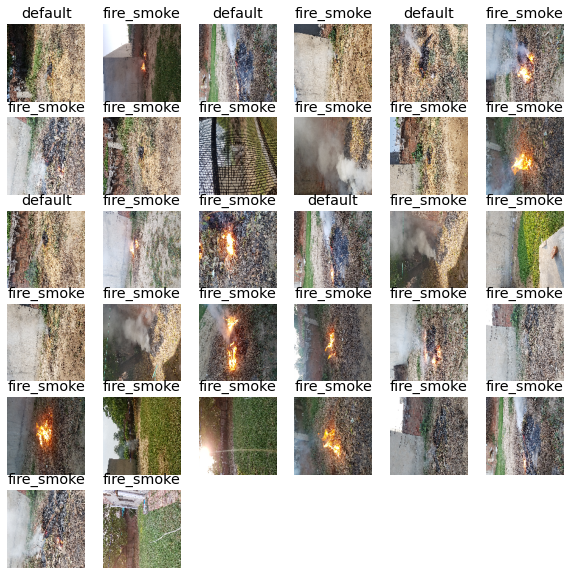

In [ ]:
image_batch, label_batch = next(test_generator)
#image_batch = colorImage.rotate(45)
plot_predictions(image_batch,my_model.predict(image_batch))
print(classification_report(label_batch,
	my_model.predict(image_batch), target_names= class_name))